# 0. Imports

In [1]:
import random
from argparse import ArgumentParser

import einops
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor
from tqdm.auto import tqdm

# 1. Setup

In [2]:
# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

Next, we define a few parameters for our experiment. In particular, we decide if we want to run the training loop, whether we want to use the Fashion-MNIST dataset and some training hyper-parameters

In [4]:
no_train = False
fashion = True
batch_size = 128
n_epochs = 20
lr = 0.001
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

Here's a few options you should set:

- `no_train` specifies whether you want to skip the training loop and just use a pre-trained model. If you haven't trained a model already using this notebook, keep this as `False`. If you want to use a pre-trained model, load it in the colab filesystem.

- `fashion` specifies whether you want to use the Fashion-MNIST dataset (`True`) or not and use the MNIST dataset instead (`False`).

- `batch_size`, `n_epochs` and `lr` are your typical training hyper-parameters. Notice that `lr=0.001` is the hyper-parameter used by the authors.

Next, we would really like to display images. Both the training images and those generated by the model are of interest to us. We write a utility function that given some images, will display a square (or as close as it gets) grid of sub-figures:

# 2. Utility Functions

In [5]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

To test this utility function, we load our dataset and show the first batch. 
> **Important**: Images must be normalized in the range [-1, 1], as our network will have to predict noise values that are normally distributed:

In [6]:
# Shows the first batch of images
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

# 3. Loading Data

We will use the MNIST (or FashionMNIST) dataset and try to generate some new samples out of (nowhere, but starting from some) random gaussian noise. 
> **NOTE**: It is important to normalize images in range `[-1,1]` and not `[0,1]` as one might usually do. This is because the DDPM network predicts normally distributed noises throughout the denoising process.

In [7]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose(
    [ToTensor(), Lambda(lambda x: (x - 0.5) * 2)]  # initially x is between 0 and 1
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\FashionMNIST\raw



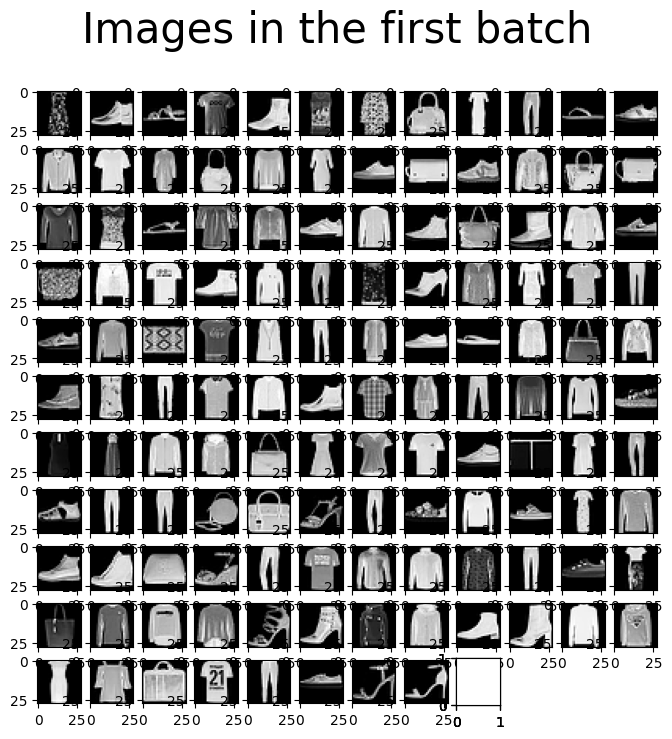

In [8]:
show_first_batch(loader)

In [9]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Using device: {device}\t"
    + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")
)

Using device: cpu	CPU


# 4. The DDPM Model

We now proceed and define a DDPM PyTorch module. Since in principle the DDPM scheme is independent of the model architecture used in each denoising step, we define a high-level model that is constructed using a `network` parameter, as well as:

- `n_steps`: number of diffusion steps T;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;
- `image_chw`: tuple contining dimensionality of images.

The `forward` process of DDPMs benefits from a nice property: We don't actually need to slowly add noise step-by-step, but we can directly skip to whathever step $t$ we want using coefficients $\alpha_b ar$.

For the `backward` method instead, we simply let the network do the job.

Note that in this implementation, $t$ is assumed to be a `(N, 1)` tensor, where `N` is the number of images in tensor `x`. We thus support different time-steps for multiple images.

In [10]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(
        self,
        network,
        n_steps=200,
        min_beta=10**-4,
        max_beta=0.02,
        device=None,
        image_chw=(1, 28, 28),
    ):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device
        )  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor(
            [torch.prod(self.alphas[: i + 1]) for i in range(len(self.alphas))]
        ).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = (
            a_bar.sqrt().reshape(n, 1, 1, 1) * x0
            + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        )
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)